<a href="https://colab.research.google.com/github/shouryam01/Spam-Detector-App/blob/main/Spam_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pickle

sns.set_style('whitegrid')
sns.set_palette('Set2')

In [ ]:
# Loading the Libraries::
df = pd.read_csv('./spam.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
# Check if Data is Duplicate or not:
df.duplicated().sum()

np.int64(415)

In [ ]:
df.drop_duplicates(inplace=True) # Remove the Duplicates

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5157 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5157 non-null   object
 1   Message   5157 non-null   object
dtypes: object(2)
memory usage: 120.9+ KB


In [ ]:
df.Category.value_counts()

,count
Category,
ham,4516
spam,641


<Axes: xlabel='Category', ylabel='count'>

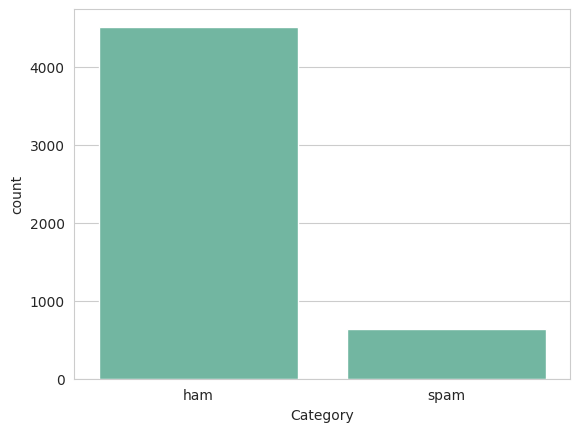

In [ ]:
# Let's Visualize the Data and Check for Findings:
sns.barplot(x = df.Category.value_counts().index, y = df.Category.value_counts())

<Axes: xlabel='Message', ylabel='Count'>

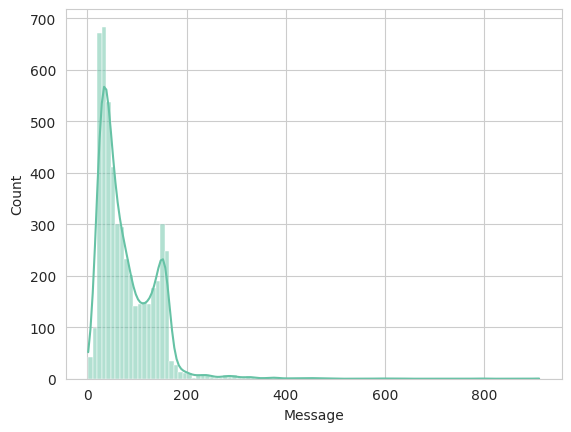

In [ ]:
# As we can see from above the data is imbalanced
sns.histplot(df['Message'].apply(len), bins=100, kde=True)   # The Message length lies between range of 0-300

<ipython-input-19-b3827cf9556c>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('Category').apply(lambda x: x['Message'].apply(len).mean()).plot(
<ipython-input-19-b3827cf9556c>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('Category').apply(lambda x: x['Message'].apply(lambda x: len(x.split())).mean()).plot(
<ipython-input-19-b3827cf9556c>:8: DeprecationWarning: DataFrameGroupBy.a

<Axes: title={'center': 'Average Number of Sentences'}, xlabel='type', ylabel='sentences'>

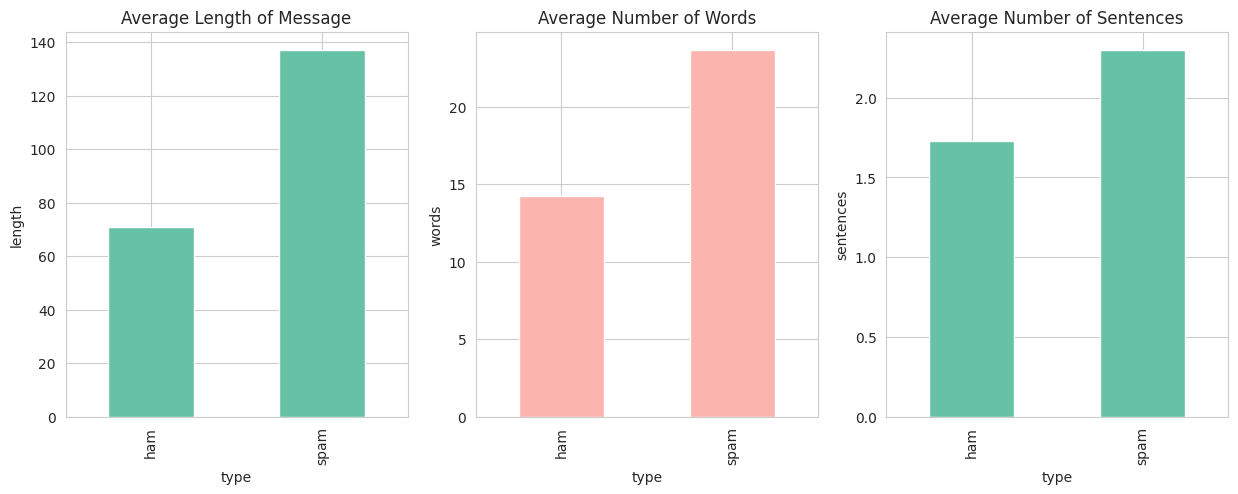

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
df.groupby('Category').apply(lambda x: x['Message'].apply(len).mean()).plot(
    kind="bar", ax=ax1, title="Average Length of Message", xlabel="type", ylabel="length")

df.groupby('Category').apply(lambda x: x['Message'].apply(lambda x: len(x.split())).mean()).plot(
    kind="bar", ax=ax2, title="Average Number of Words", xlabel="type", ylabel="words", colormap="Pastel1")

df.groupby('Category').apply(lambda x: x['Message'].apply(lambda x: len(x.split(". "))).mean()).plot(
    kind="bar", ax=ax3, title="Average Number of Sentences", xlabel="type", ylabel="sentences")

(np.float64(-0.5), np.float64(799.5), np.float64(511.5), np.float64(-0.5))

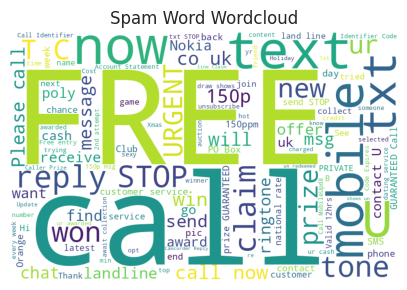

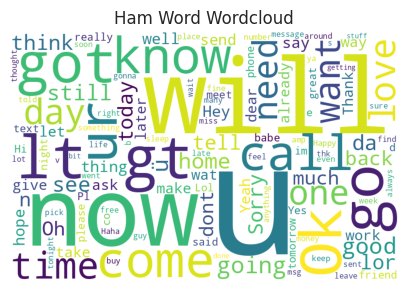

In [ ]:
spam_words = ' '.join(list(df[df['Category'] == 'spam']['Message']))    # Taking out the Spam words together
spam_wc = WordCloud(width=800, height=512, max_words=120, background_color='white').generate(spam_words)

plt.figure(figsize = (5, 6))
plt.title('Spam Word Wordcloud')
plt.imshow(spam_wc)
plt.axis('off')


ham_words = ' '.join(list(df[df['Category'] == 'ham']['Message']))    # Taking out the Ham words together
ham_wc = WordCloud(width=800, height=512, max_words=120, background_color='white').generate(ham_words)

plt.figure(figsize = (5, 6))
plt.title('Ham Word Wordcloud')
plt.imshow(ham_wc)
plt.axis('off')

In [ ]:
# Preprocessing
df['Message'].sample(5)

,Message
4262,Pls dont forget to study
1317,Why nothing. Ok anyway give me treat
1911,Becoz its &lt;#&gt; jan whn al the post ofic...
1315,Got but got 2 colours lor. One colour is quite...
5064,Ok i also wan 2 watch e 9 pm show...


In [ ]:
# Find out the Stopwords from the Message
nltk.download('stopwords')
stopwrd = stopwords.words('english')
def clean_text(text):

  text = text.lower()  # Lowercasing the Letters
  text = re.sub('-', ' ', text.lower())  # Replacing `x-x` as `x x`
  text = re.sub(r'http\S+', '', text) # Removing Links
  text = re.sub(f'[{string.punctuation}]', '', text)  # Remove punctuations
  text = re.sub(r'\s+', ' ', text)  # Removing Unnecessary spaces
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Removing Single chars

  words = nltk.tokenize.word_tokenize(text, language="english", preserve_line=True)
  text = " ".join([i for i in words if i not in stopwrd and len(i)>2]) # Removing the StopWords

  return text.strip()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df["clean_text"] = df["Message"].apply(clean_text)
df

,Category,Message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts 21st m...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried contact £750 pound prize claim ...
5568,ham,Will ü b going to esplanade fr home?,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...


In [ ]:
# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['Category'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4125,), (1032,), (4125,), (1032,))

In [ ]:
X_train.head()

,clean_text
2598,got fujitsu ibm toshiba got lot model say
5418,really hows masters
99,see cup coffee animation
2321,pain couldnt come worse time
2388,also wheres piece


In [ ]:
# Vectorizing
# vectorizer = CountVectorizer(stop_words='english', lowercase=True)
vectorizer = TfidfVectorizer(stop_words='english',max_features=10000,ngram_range=(1,3),lowercase=True)
X_train_vectorizer = vectorizer.fit_transform(X_train)
X_test_vectorizer = vectorizer.fit_transform(X_test)

In [ ]:
X_train_vectorizer.shape, X_test_vectorizer.shape

((4125, 10000), (1032, 10000))

In [ ]:
labelEnco = LabelEncoder()
y_train = labelEnco.fit_transform(y_train)
y_test = labelEnco.fit_transform(y_test)

<Axes: xlabel='0'>

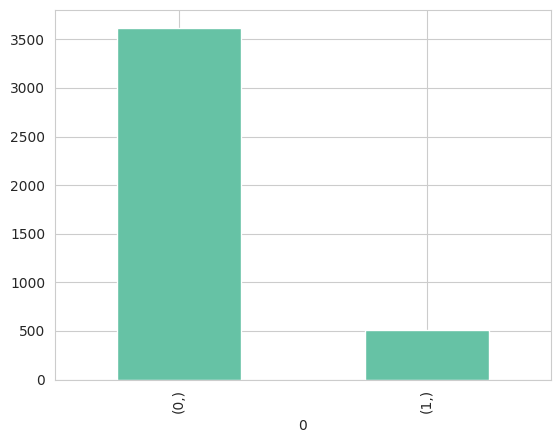

In [ ]:
pd.DataFrame(y_train).value_counts().plot(kind='bar')

In [ ]:
# Balance Botht Classes Using RandomOverSample

sampler = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = sampler.fit_resample(X_train_vectorizer, y_train)

<Axes: xlabel='0'>

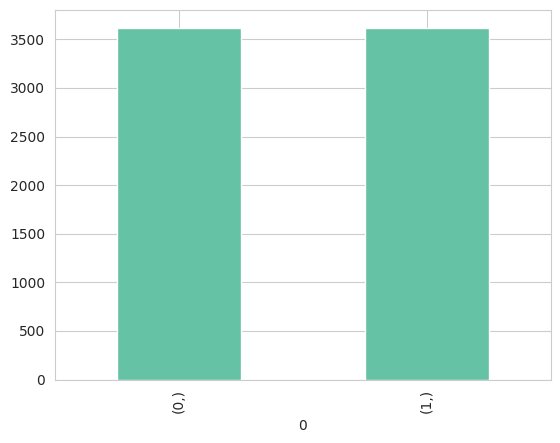

In [ ]:
pd.DataFrame(y_train_resampled).value_counts().plot(kind='bar')

In [ ]:
# Now comes the Modelling Part:
# Logistic Regression
lr = LogisticRegression(C=1000,solver='sag', max_iter=500, random_state=15)
lr.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1000, max_iter=500, random_state=15, solver='sag')

In [ ]:
model_filename = 'spam_detector_logistic_regression.pkl'

# Save the model to a file
with open(model_filename, 'wb') as file:
    pickle.dump(lr, file)

In [ ]:
# Logistic Regression
print("Train Accuracy: ", lr.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", lr.score(X_test_vectorizer, y_test))
print("Train Precision: ", precision_score(y_train_resampled, lr.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, lr.predict(X_test_vectorizer)))


Train Accuracy:  0.998756906077348
Test Accuracy:  0.813953488372093
Train Precision:  1.0
Test Precision:  0.27419354838709675


In [ ]:
# Multinomial Naive Bayes:
cnb = MultinomialNB(alpha=0.1)
cnb.fit(x_train_resampled,y_train_resampled)

MultinomialNB(alpha=0.1)

In [ ]:
model_filename = 'spam_detector_MultiNB.pkl'

# Save the model to a file
with open(model_filename, 'wb') as file:
    pickle.dump(cnb, file)

In [ ]:
print("Train Accuracy: ", cnb.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", cnb.score(X_test_vectorizer, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, cnb.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, cnb.predict(X_test_vectorizer)))

Train Accuracy:  0.9919889502762431
Test Accuracy:  0.7228682170542635
Train Precision:  0.9919889502762431
Test Precision:  0.21804511278195488


In [ ]:
# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_resampled,y_train_resampled)
rf.fit(x_train_resampled,y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
model_filename = 'spam_detector_random_forest.pkl'

# Save the model to a file
with open(model_filename, 'wb') as file:
    pickle.dump(rf, file)

In [ ]:
print("Train Accuracy: ", rf.score(x_train_resampled, y_train_resampled))
print("Test Accuracy: ", rf.score(X_test_vectorizer, y_test))
print("Train Precision: ", precision_score(
    y_train_resampled, rf.predict(x_train_resampled)))
print("Test Precision: ", precision_score(y_test, rf.predict(X_test_vectorizer)))

Train Accuracy:  0.998756906077348
Test Accuracy:  0.8643410852713178
Train Precision:  1.0
Test Precision:  0.4166666666666667


In [ ]:
# Scores

y_pred_train_lr = lr.predict(x_train_resampled)
y_pred_test_lr = lr.predict(X_test_vectorizer)

y_pred_train_cnb = cnb.predict(x_train_resampled)
y_pred_test_cnb = cnb.predict(X_test_vectorizer)

y_pred_train_rf = rf.predict(x_train_resampled)
y_pred_test_rf = rf.predict(X_test_vectorizer)


In [ ]:
input1 =''' Hi, I am a student of Charusat University. I am writing this mail to inform you that I have been selected for the internship at Google. I am very excited to work with you.'''
input2 = '''You have won a lottery of 1 million dollars. Please send your bank details to claim the prize.'''
# input = clean_text(input1)
input = clean_text(input2)
print(input)
input = vectorizer.transform([input])
print(labelEnco.inverse_transform(rf.predict(input)))

lottery million dollars please send bank details claim prize
[0]
